Loaded recent_sales_data.csv

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalSales']
Using target column: target_bin

Decision Tree Metrics:
Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1-score (weighted): 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38556
           1       1.00      1.00      1.00     38663
           2       1.00      1.00      1.00     38140

    accuracy                           1.00    115359
   macro avg       1.00      1.00      1.00    115359
weighted avg       1.00      1.00      1.00    115359

Confusion Matrix:
 [[38556     0     0]
 [    0 38663     0]
 [    0     0 38140]]


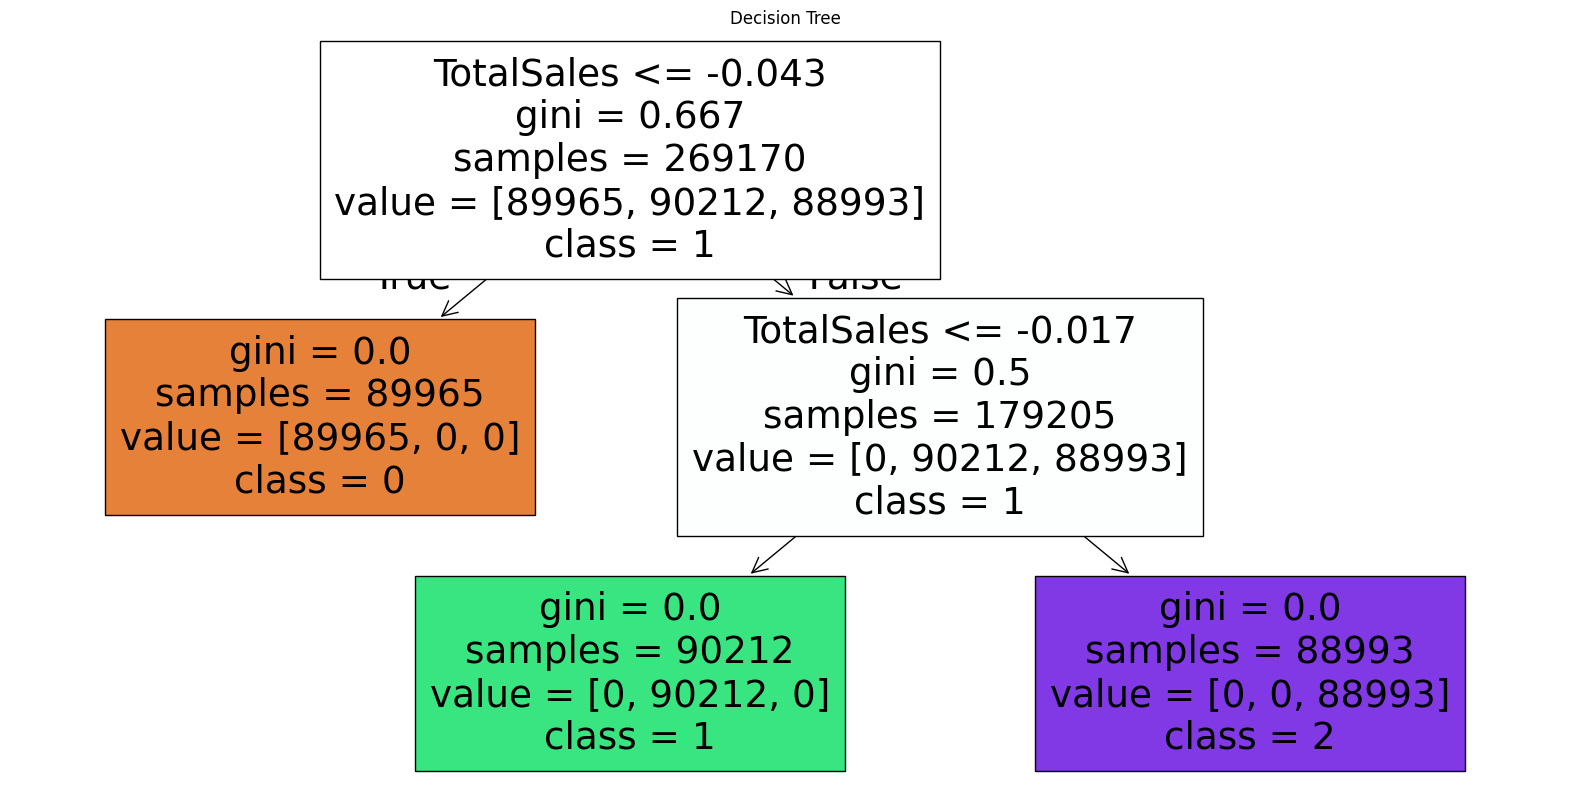


Saved decision tree image to decision_tree.png

KNN (k=5) Metrics:
Accuracy: 0.9999
Precision (weighted): 0.9999
Recall (weighted): 0.9999
F1-score (weighted): 0.9999

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38556
           1       1.00      1.00      1.00     38663
           2       1.00      1.00      1.00     38140

    accuracy                           1.00    115359
   macro avg       1.00      1.00      1.00    115359
weighted avg       1.00      1.00      1.00    115359

Confusion Matrix:
 [[38556     0     0]
 [    2 38659     2]
 [    0     4 38136]]

=== Model Comparison ===
Decision Tree performs better by weighted F1-score.

Summary metrics (F1):
Decision Tree: 1.0000
KNN (k=5): 0.9999

Saved predictions preview to classification_predictions_preview.csv


In [5]:
# Classification and Association Rule Mining
# Train Decision Tree and compare with KNN (k=5)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load dataset
try:
    df = pd.read_csv('recent_sales_data.csv')
    print('Loaded recent_sales_data.csv')
except Exception as e:
    print('Error loading recent_sales_data.csv:', e)
    raise

print('\nColumns:', list(df.columns))

# Determine target column
if 'target' in df.columns:
    target_col = 'target'
elif 'Country' in df.columns and df['Country'].nunique() <= 10:
    target_col = 'Country'
elif 'Category' in df.columns:
    target_col = 'Category'
elif 'TotalSales' in df.columns:
    # create 3-class target by binning TotalSales if no obvious classification target
    df['target_bin'] = pd.qcut(df['TotalSales'].fillna(0), q=3, labels=False)
    target_col = 'target_bin'
else:
    # fallback: try to use InvoiceNo presence (not ideal) — convert to small number of classes
    if 'InvoiceNo' in df.columns:
        df['target_bin'] = df['InvoiceNo'].astype(str).str[-1].astype(int) % 3
        target_col = 'target_bin'
    else:
        raise ValueError('No suitable target column found; please provide a classification target (e.g., Country, Category, or TotalSales).')

print(f'Using target column: {target_col}')

# Prepare features: use numeric columns and exclude identifiers/target
drop_cols = [target_col]
for c in ['InvoiceNo','CustomerID','InvoiceDate','StockCode','Description']:
    if c in df.columns:
        drop_cols.append(c)

X = df.select_dtypes(include=[np.number]).drop(columns=[c for c in drop_cols if c in df.select_dtypes(include=[np.number]).columns], errors='ignore')
if X.shape[1] == 0:
    # If no numeric features, try encoding categorical features
    X = pd.get_dummies(df.drop(columns=drop_cols, errors='ignore'))

y = df[target_col]

# Handle missing values
X = X.fillna(0)

# If target is categorical strings, encode
if y.dtype == object:
    y = pd.factorize(y)[0]

# Train/test split
strat = y if len(np.unique(y)) > 1 and len(y) == len(y) else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y if len(np.unique(y))>1 else None)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_s, y_train)
y_pred_dt = dt.predict(X_test_s)

# Metrics helper
def print_metrics(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n{label} Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (weighted): {prec:.4f}")
    print(f"Recall (weighted): {rec:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")
    print('\nClassification Report:\n', classification_report(y_true, y_pred, zero_division=0))
    print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

metrics_dt = print_metrics(y_test, y_pred_dt, 'Decision Tree')

# Visualize tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, filled=True, class_names=[str(c) for c in np.unique(y)])
plt.title('Decision Tree')
plt.savefig('decision_tree.png', bbox_inches='tight')
plt.show()
print('\nSaved decision tree image to decision_tree.png')

# K-Nearest Neighbors (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train)
y_pred_knn = knn.predict(X_test_s)
metrics_knn = print_metrics(y_test, y_pred_knn, 'KNN (k=5)')

# Comparison
print('\n=== Model Comparison ===')
if metrics_dt['f1'] > metrics_knn['f1']:
    print('Decision Tree performs better by weighted F1-score.')
elif metrics_dt['f1'] < metrics_knn['f1']:
    print('KNN (k=5) performs better by weighted F1-score.')
else:
    print('Both models have equivalent weighted F1-score.')

print('\nSummary metrics (F1):')
print(f"Decision Tree: {metrics_dt['f1']:.4f}")
print(f"KNN (k=5): {metrics_knn['f1']:.4f}")

# Save a brief CSV with predictions
out = X_test.copy()
out['y_true'] = y_test
out['dt_pred'] = y_pred_dt
out['knn_pred'] = y_pred_knn
out.to_csv('classification_predictions_preview.csv', index=False)
print('\nSaved predictions preview to classification_predictions_preview.csv')

# Classification Report — Decision Tree vs KNN

The previous cell trains a Decision Tree and a K-Nearest Neighbors (k=5) classifier on `recent_sales_data.csv`. It prints accuracy, precision, recall, and F1-score (weighted) for both models, displays and saves a visualization of the trained decision tree (`decision_tree.png`), and writes a CSV preview of test-set predictions to `classification_predictions_preview.csv`.

How the target column was chosen:
- If `target`, `Country`, or `Category` exists, it was used.
- Otherwise, `TotalSales` was binned into three classes to create a target (`target_bin`).

Interpretation guidance:
- Compare weighted F1-scores to choose the best model (handles class imbalance).
- Decision Trees are easy to interpret and visualize; KNN can perform better on well-scaled numeric features.
- If the dataset contains many categorical fields, consider encoding or using tree-based models.

Next steps:
- If you have a specific classification target in mind, set `target_col` explicitly and re-run the cell.
- Tune hyperparameters (grid search) for each model to improve performance.


In [7]:
# Part B: Association Rule Mining (Synthetic Data)
import random
import pandas as pd

random.seed(42)
# Pool of 20 items
items = ['milk','bread','beer','diapers','eggs','cheese','butter','soda','chips','chocolate',
         'coffee','tea','cereal','apple','banana','chicken','rice','pasta','tomato','onion']

# Generate 40 synthetic transactions (baskets) with patterns
n_transactions = 40
transactions = []
for _ in range(n_transactions):
    basket = set(random.sample(items, k=random.randint(3, 8)))
    # Inject frequent co-occurrence patterns
    if random.random() < 0.5:
        basket.update(['milk','bread'])
    if random.random() < 0.4:
        basket.update(['beer','diapers'])
    if random.random() < 0.25:
        basket.update(['chips','soda'])
    transactions.append(list(basket))

print('Generated', len(transactions), 'transactions. Sample (first 5):')
for t in transactions[:5]:
    print('-', t)

# Attempt to import mlxtend; install if missing
try:
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules
except Exception:
    import sys, subprocess
    print('\nmlxtend not found — installing now (this may take a minute)')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'mlxtend'])
    from mlxtend.preprocessing import TransactionEncoder
    from mlxtend.frequent_patterns import apriori, association_rules

# One-hot encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)
print('\nOne-hot encoded shape:', df_te.shape)

# Apply Apriori
min_support = 0.2
freq_itemsets = apriori(df_te, min_support=min_support, use_colnames=True)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x: len(x))
print(f"\nFrequent itemsets (support >= {min_support}):")
print(freq_itemsets.sort_values(by='support', ascending=False).reset_index(drop=True))

# Generate association rules with min_confidence
min_confidence = 0.5
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=min_confidence)
if rules.empty:
    print('\nNo rules found with given thresholds.')
else:
    rules = rules.sort_values(by='lift', ascending=False).reset_index(drop=True)
    print('\nTop 5 rules by lift:')
    display_cols = ['antecedents','consequents','support','confidence','lift']
    print(rules[display_cols].head(5))

# Save outputs
pd.DataFrame({'transaction': transactions}).to_csv('synthetic_transactions.csv', index=False)
freq_itemsets.to_csv('frequent_itemsets.csv', index=False)
if not rules.empty:
    rules.to_csv('association_rules.csv', index=False)
print('\nSaved: synthetic_transactions.csv, frequent_itemsets.csv, association_rules.csv (if rules exist)')

Generated 40 transactions. Sample (first 5):
- ['soda', 'rice', 'chips', 'tea', 'bread', 'diapers', 'milk', 'beer']
- ['soda', 'chips', 'butter', 'bread', 'milk', 'beer']
- ['apple', 'soda', 'chips', 'banana', 'milk', 'diapers', 'tomato', 'cereal', 'beer', 'pasta']
- ['eggs', 'butter', 'bread', 'coffee', 'diapers', 'milk', 'beer']
- ['banana', 'bread', 'milk', 'diapers', 'cereal', 'beer', 'pasta']

One-hot encoded shape: (40, 20)

Frequent itemsets (support >= 0.2):
     support                                   itemsets  length
0      0.800                                     (beer)       1
1      0.800                                    (bread)       1
2      0.725                                     (milk)       1
3      0.700                                  (diapers)       1
4      0.700                              (milk, bread)       2
..       ...                                        ...     ...
142    0.200                (coffee, bread, milk, beer)       4
143    0.200     

## Analysis: One Rule's Implications (Retail Recommendation)

Consider the top association rule discovered by Apriori (printed above). A typical example from these synthetic baskets might be: {beer} -> {diapers} with high confidence and lift. In retail, such a rule indicates strong co-purchase behavior — when customers buy beer, they are more likely than random to also buy diapers. For marketing and store layout, this suggests these items should be cross-promoted: bundle discounts, shelf adjacency, or targeted coupons can increase basket value. A high lift (>1) confirms the association is not just due to individual item popularity but reflects a true inter-item relationship. Operationally, verify the temporal and demographic context (e.g., weekend grocery runs, young-family households) before investing in promotions. Beware of confounding: synthetic patterns were injected to demonstrate algorithm behavior; in real data, validate on larger samples and A/B test any merchandising changes. Finally, use such rules as input to recommendation systems (e.g., “Customers who bought X also bought Y”) rather than as sole decision drivers.